# Packages and functions

In [3]:
import os
import time
import umap
import random
import numpy as np
import pandas as pd
import colorsys as cs
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cdist
# from cuml.manifold.umap import UMAP as cuUMAP

def get_col(coords):
    plot_df = coords.copy()
    my_h = plot_df['xcoord']
    my_h = (my_h - np.min(my_h))
    my_h = 0.2+my_h * (0.8 / np.max(my_h))
    my_s = np.ones(len(my_h)) * 0.5
    my_l = plot_df['ycoord']
    my_l = (my_l - np.min(my_l))
    my_l = 0.2 + my_l * (0.7 / np.max(my_l))
    hls_color = np.column_stack((my_h, my_l, my_s))
    rgb_color = [cs.hls_to_rgb(p[0], p[1], p[2]) for p in hls_color]
    return rgb_color

def get_pa(pos_truth,pos_recon):
    mtx1, mtx2, disparity = procrustes(pos_truth[['xcoord','ycoord']], pos_recon[['xcoord','ycoord']])
    
    pos_truth_translate = pos_truth.copy()
    pos_truth_translate['xcoord'] = pos_truth_translate['xcoord'] - np.mean(pos_truth_translate['xcoord'])
    pos_truth_translate['ycoord'] = pos_truth_translate['ycoord'] - np.mean(pos_truth_translate['ycoord'])
    
    scaling = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))
    scaling_2 = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))/np.sqrt(np.trace(np.dot(mtx2, mtx2.T)))

    mtx1_scaled = mtx1*scaling
    mtx2_scaled = mtx2*scaling_2
    
    dist = pos_truth_translate.copy()
    dist['x'] = mtx1_scaled[:,0] - mtx2_scaled[:,0]
    dist['y'] = mtx1_scaled[:,1] - mtx2_scaled[:,1]
    dist['r'] = np.sqrt(dist['x']**2 + dist['y']**2)
    
    return disparity, mtx1_scaled, mtx2_scaled, dist

# Load image

load coordinates and corresponding RGBA color of each pixels from a image

In [4]:
coords_all = pd.read_pickle("/example_data/coordinate.pkl") 
color_all = pd.read_pickle("/example_data/rgb.pkl") 
color_all = [(c[0]/255,c[1]/255,c[2]/255,c[3]/255) for c in color_all]

randomly downsample the pixels as beads, and separate them into fiducial beads and capture beads

In [19]:
bead_ind = random.sample(range(len(coords_all)), 20000)

a_ind = bead_ind[:10000] # capture beads
t_ind = bead_ind[10000:] # fiducial beads

display the image of capture beads and corresponding colors

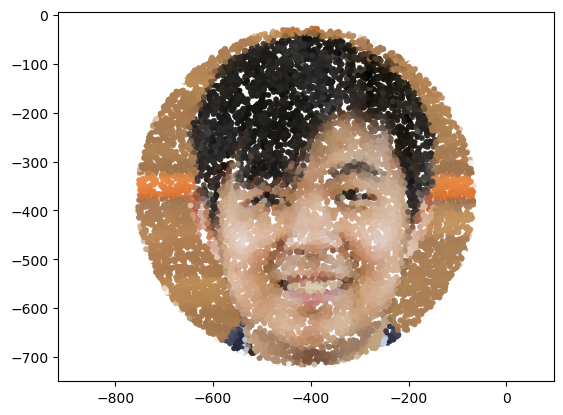

In [35]:
sns.scatterplot(x=-np.array(coords_all)[a_ind,0],y=-np.array(coords_all)[a_ind,1],c=[color_all[i] for i in a_ind],s=15,edgecolor=None)
plt.axis('equal')
plt.show()

In [37]:
coords_a_truth = np.array(coords_all)[a_ind,:]
coords_t_truth = np.array(coords_all)[t_ind,:]

# Simulation of diffusion

simulate diffusion between capture beads and fiducial beads based on Gaussian distribution

In [38]:
sigma = 50
UMI = 100

distances = cdist(coords_a_truth, coords_t_truth)
proba = np.exp(-distances**2 / (2*sigma**2))
proba = proba / proba.sum(axis=1, keepdims=True)
counts = proba

generated a fiducial bead by capture bead diffusion matrix

In [40]:
np.shape(counts)

(10000, 10000)

# UMAP reconstruction

use UMAP to embedding fiducial bead by capture bead diffusion matrix to two dimensional

In [41]:
time5 = time.time()
reducer = umap.UMAP(metric='cosine',
                    n_neighbors=25, 
                    min_dist=0.99, 
                    low_memory=False, 
                    n_components=2, 
                    # random_state=0, 
                    verbose=True,           
                    n_epochs=10000,
                    # output_dens = True,
                    # local_connectivity = 30,
                    learning_rate = 1)
embedding = reducer.fit_transform(counts)
time_loop = time.time()
print('umap: ', time_loop-time5)

UMAP(angular_rp_forest=True, learning_rate=1, low_memory=False, metric='cosine', min_dist=0.99, n_epochs=10000, n_neighbors=25, verbose=True)
Tue Apr 16 21:34:11 2024 Construct fuzzy simplicial set
Tue Apr 16 21:34:11 2024 Finding Nearest Neighbors
Tue Apr 16 21:34:11 2024 Building RP forest with 10 trees
Tue Apr 16 21:34:12 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Tue Apr 16 21:34:27 2024 Finished Nearest Neighbor Search
Tue Apr 16 21:34:29 2024 Construct embedding


Epochs completed:   0%|            0/10000 [00:00]

	completed  0  /  10000 epochs
	completed  1000  /  10000 epochs
	completed  2000  /  10000 epochs
	completed  3000  /  10000 epochs
	completed  4000  /  10000 epochs
	completed  5000  /  10000 epochs
	completed  6000  /  10000 epochs
	completed  7000  /  10000 epochs
	completed  8000  /  10000 epochs
	completed  9000  /  10000 epochs
Tue Apr 16 21:36:39 2024 Finished embedding
umap:  149.01879978179932


Display embedding result of capture beads in 2D

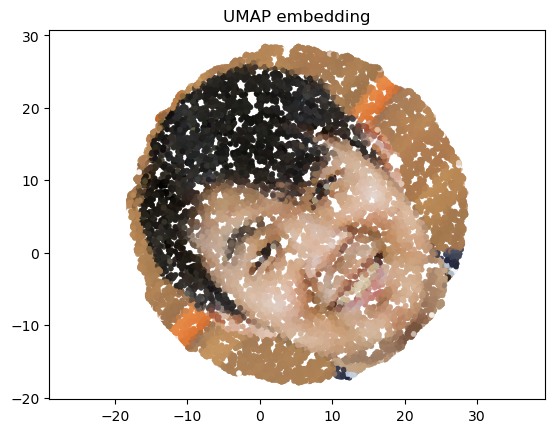

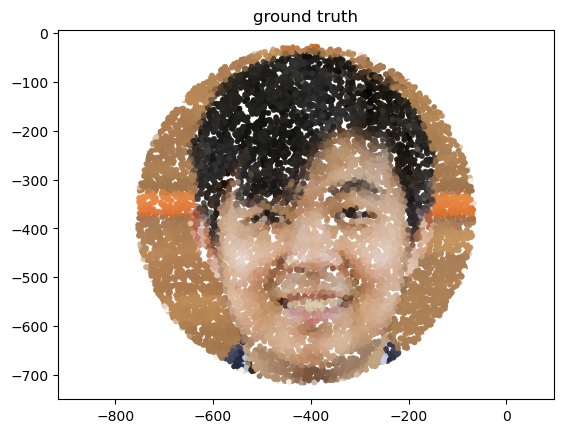

In [45]:
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],c=[color_all[i] for i in a_ind],s=15,edgecolor=None)
plt.title('UMAP embedding')
plt.axis('equal')
plt.show()

sns.scatterplot(x=-np.array(coords_all)[a_ind,0],y=-np.array(coords_all)[a_ind,1],c=[color_all[i] for i in a_ind],s=15,edgecolor=None)
plt.title('ground truth')
plt.axis('equal')
plt.show()